In [10]:
#change directory
import os
os.chdir('/Users/kaixianglim/Documents/DSS5104/Group_Project/5-min frequency data/FINAL')

import numpy as np 
import pylab as plt
import pandas as pd
import sklearn
from scipy.stats import zscore
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV


## ENERGY PRICE DATA

In [ ]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [12]:
#df header
df.head()

timestamp  Energy_Demand  Energy_Price  Crude_Oil_Price  \
0  3/1/22 0:00        7294.03      4.370966            78.25   
1  3/1/22 0:05        7304.76      4.507557            78.25   
2  3/1/22 0:10        7176.53      4.476996            78.25   
3  3/1/22 0:15        7247.72      4.497028            78.25   
4  3/1/22 0:20        7169.96      4.478132            78.25   

   Natural_Gas_Price  Rainfall  Carbon_Intensity  Renewable_Energy_Percentage  \
0               3.74       0.0            313.43                        58.81   
1               3.74       0.0            313.43                        58.81   
2               3.74       0.0            313.43                        58.81   
3               3.74       0.0            313.43                        58.81   
4               3.74       0.0            313.43                        58.81   

   Temperature  Solar_Exposure  hour  dayofweek  month     lag_1  lag_12  \
0           22               0     0          0      1       NaN     NaN   
1           22               0     0          0      1  4.370966     NaN   
2           22               0     0          0      1  4.507557     NaN   
3           22               0     0          0      1  4.476996     NaN   
4           22               0     0          0      1  4.497028     NaN   

   lag_288  lag_576  rolling_mean_24  rolling_std_24  
0      NaN      NaN              NaN             NaN  
1      NaN      NaN              NaN             NaN  
2      NaN      NaN              NaN             NaN  
3      NaN      NaN              NaN             NaN  
4      NaN      NaN              NaN             NaN

In [13]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [14]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

In [15]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [16]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 0.2156
Mean Squared Error on the Test Set: 0.2025
Root Mean Squared Error on the Test Set: 0.4500
R^2 Score: 0.7138
Adjusted R^2 Score: 0.7137


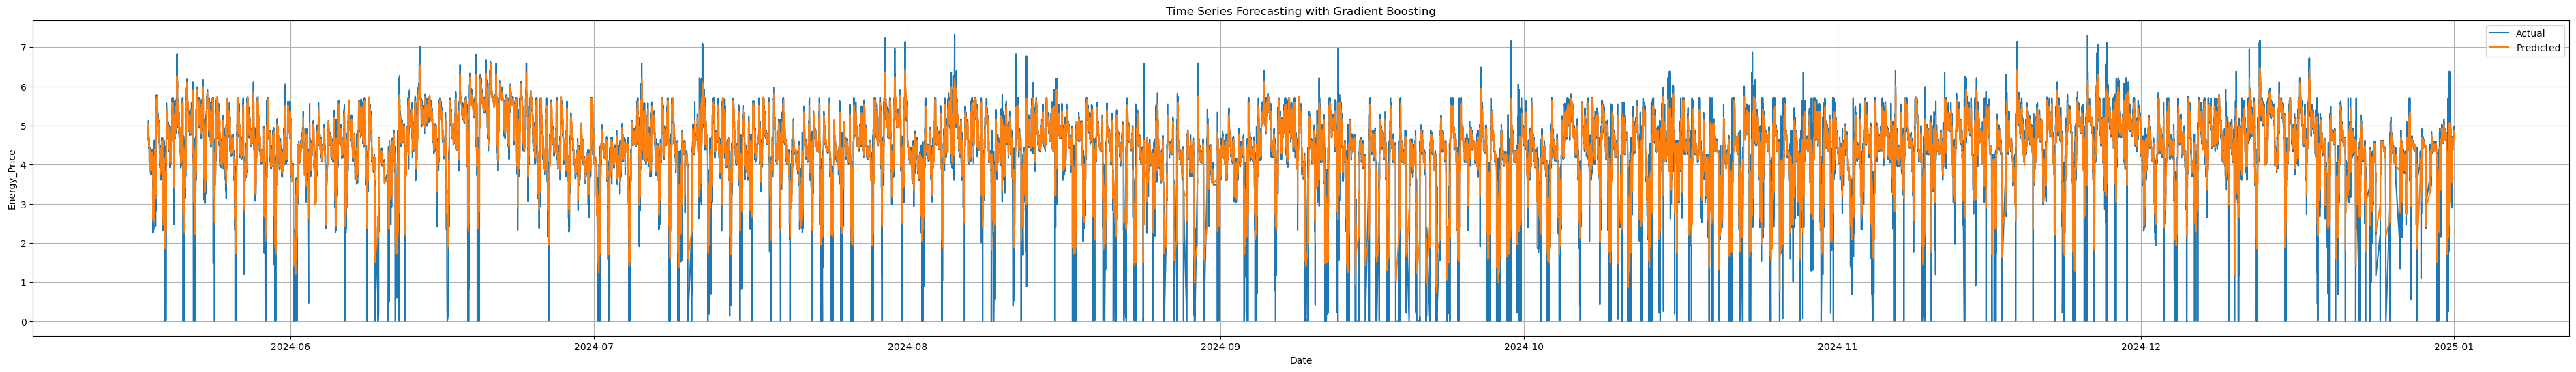

In [ ]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


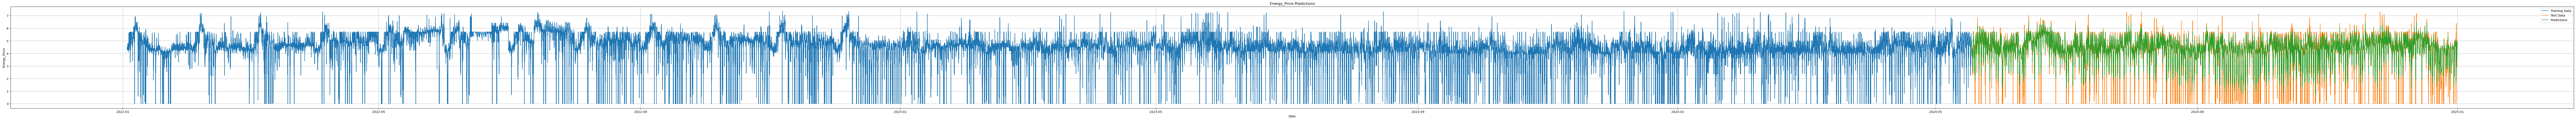

In [ ]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## FINANCE DATA

In [ ]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [ ]:
#df header
df.head()

timestamp  Energy_Demand  Energy_Price  Crude_Oil_Price  \
0  3/1/22 0:00        7294.03      4.370966            78.25   
1  3/1/22 0:05        7304.76      4.507557            78.25   
2  3/1/22 0:10        7176.53      4.476996            78.25   
3  3/1/22 0:15        7247.72      4.497028            78.25   
4  3/1/22 0:20        7169.96      4.478132            78.25   

   Natural_Gas_Price  Rainfall  Carbon_Intensity  Renewable_Energy_Percentage  \
0               3.74       0.0            313.43                        58.81   
1               3.74       0.0            313.43                        58.81   
2               3.74       0.0            313.43                        58.81   
3               3.74       0.0            313.43                        58.81   
4               3.74       0.0            313.43                        58.81   

   Temperature  Solar_Exposure  hour  dayofweek  month     lag_1  lag_12  \
0           22               0     0          0      1       NaN     NaN   
1           22               0     0          0      1  4.370966     NaN   
2           22               0     0          0      1  4.507557     NaN   
3           22               0     0          0      1  4.476996     NaN   
4           22               0     0          0      1  4.497028     NaN   

   lag_288  lag_576  rolling_mean_24  rolling_std_24  
0      NaN      NaN              NaN             NaN  
1      NaN      NaN              NaN             NaN  
2      NaN      NaN              NaN             NaN  
3      NaN      NaN              NaN             NaN  
4      NaN      NaN              NaN             NaN

In [ ]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [ ]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

In [ ]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [ ]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 0.2156
Mean Squared Error on the Test Set: 0.2025
Root Mean Squared Error on the Test Set: 0.4500
R^2 Score: 0.7138
Adjusted R^2 Score: 0.7137


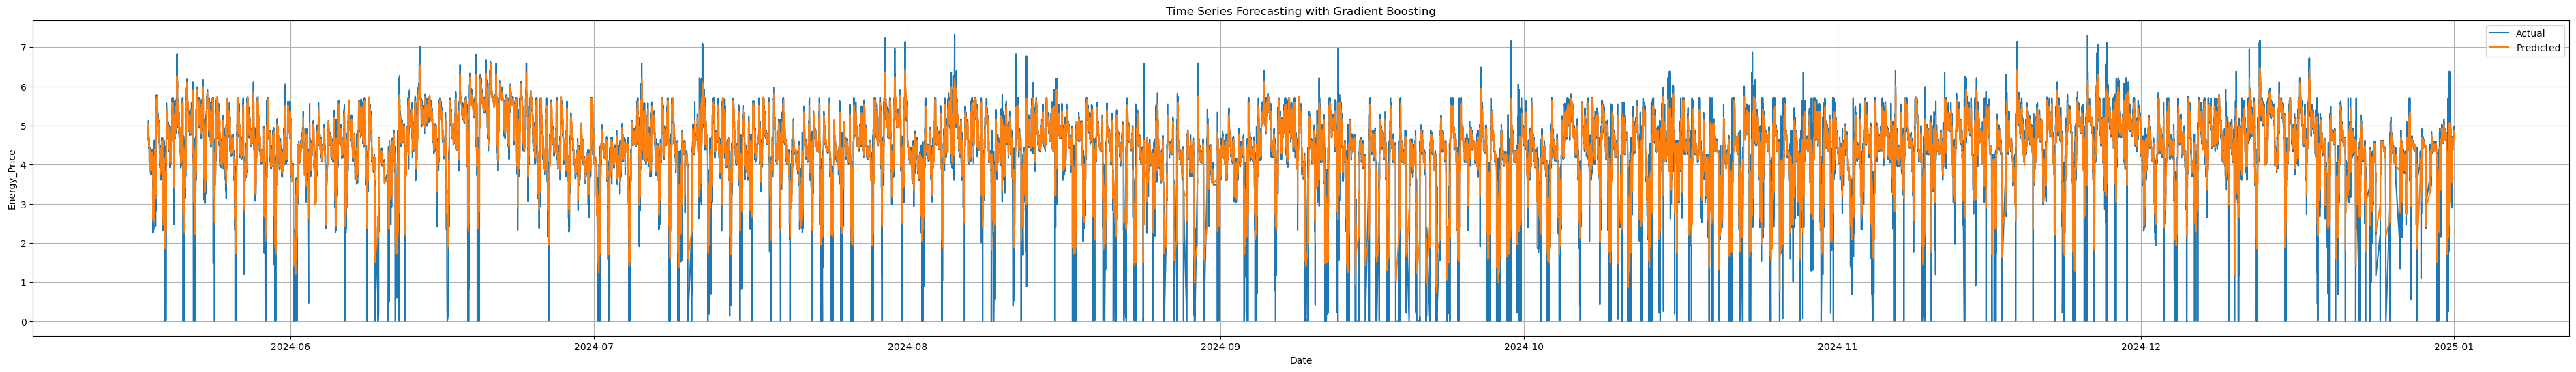

In [ ]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


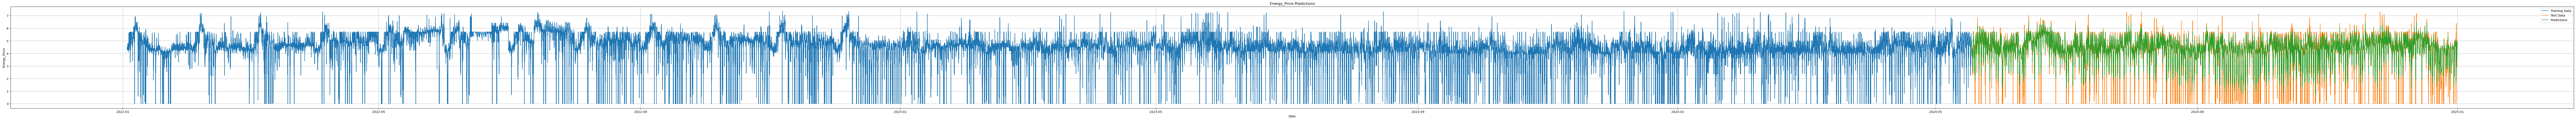

In [ ]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## CLIMATE DATA

In [ ]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [ ]:
#df header
df.head()

timestamp  Energy_Demand  Energy_Price  Crude_Oil_Price  \
0  3/1/22 0:00        7294.03      4.370966            78.25   
1  3/1/22 0:05        7304.76      4.507557            78.25   
2  3/1/22 0:10        7176.53      4.476996            78.25   
3  3/1/22 0:15        7247.72      4.497028            78.25   
4  3/1/22 0:20        7169.96      4.478132            78.25   

   Natural_Gas_Price  Rainfall  Carbon_Intensity  Renewable_Energy_Percentage  \
0               3.74       0.0            313.43                        58.81   
1               3.74       0.0            313.43                        58.81   
2               3.74       0.0            313.43                        58.81   
3               3.74       0.0            313.43                        58.81   
4               3.74       0.0            313.43                        58.81   

   Temperature  Solar_Exposure  hour  dayofweek  month     lag_1  lag_12  \
0           22               0     0          0      1       NaN     NaN   
1           22               0     0          0      1  4.370966     NaN   
2           22               0     0          0      1  4.507557     NaN   
3           22               0     0          0      1  4.476996     NaN   
4           22               0     0          0      1  4.497028     NaN   

   lag_288  lag_576  rolling_mean_24  rolling_std_24  
0      NaN      NaN              NaN             NaN  
1      NaN      NaN              NaN             NaN  
2      NaN      NaN              NaN             NaN  
3      NaN      NaN              NaN             NaN  
4      NaN      NaN              NaN             NaN

In [ ]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [ ]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

In [ ]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [ ]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 0.2156
Mean Squared Error on the Test Set: 0.2025
Root Mean Squared Error on the Test Set: 0.4500
R^2 Score: 0.7138
Adjusted R^2 Score: 0.7137


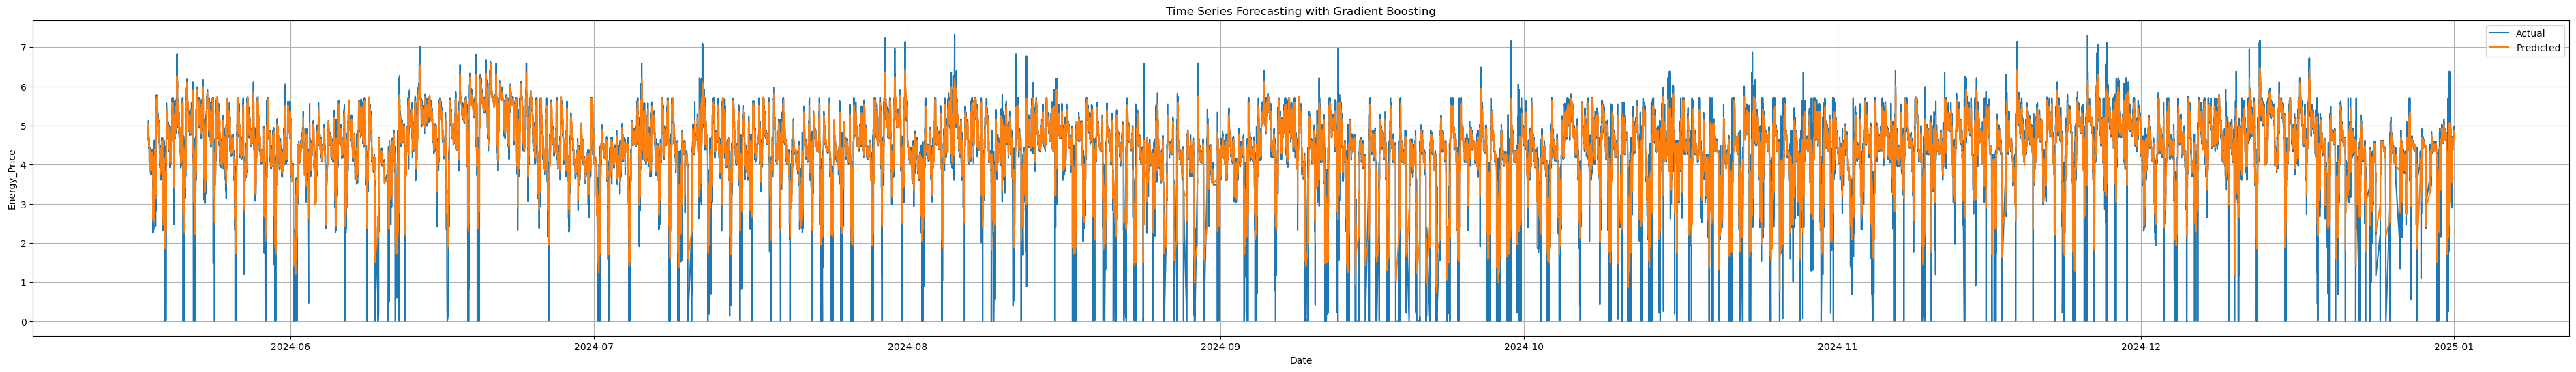

In [ ]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


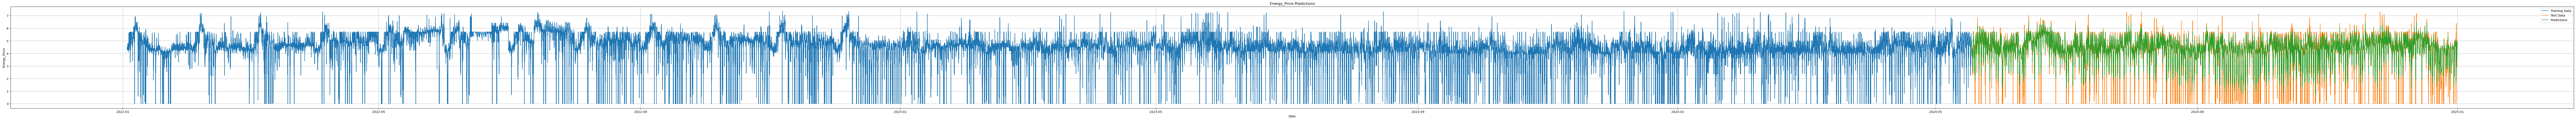

In [ ]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## RETAIL DATA

In [ ]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [ ]:
#df header
df.head()

timestamp  Energy_Demand  Energy_Price  Crude_Oil_Price  \
0  3/1/22 0:00        7294.03      4.370966            78.25   
1  3/1/22 0:05        7304.76      4.507557            78.25   
2  3/1/22 0:10        7176.53      4.476996            78.25   
3  3/1/22 0:15        7247.72      4.497028            78.25   
4  3/1/22 0:20        7169.96      4.478132            78.25   

   Natural_Gas_Price  Rainfall  Carbon_Intensity  Renewable_Energy_Percentage  \
0               3.74       0.0            313.43                        58.81   
1               3.74       0.0            313.43                        58.81   
2               3.74       0.0            313.43                        58.81   
3               3.74       0.0            313.43                        58.81   
4               3.74       0.0            313.43                        58.81   

   Temperature  Solar_Exposure  hour  dayofweek  month     lag_1  lag_12  \
0           22               0     0          0      1       NaN     NaN   
1           22               0     0          0      1  4.370966     NaN   
2           22               0     0          0      1  4.507557     NaN   
3           22               0     0          0      1  4.476996     NaN   
4           22               0     0          0      1  4.497028     NaN   

   lag_288  lag_576  rolling_mean_24  rolling_std_24  
0      NaN      NaN              NaN             NaN  
1      NaN      NaN              NaN             NaN  
2      NaN      NaN              NaN             NaN  
3      NaN      NaN              NaN             NaN  
4      NaN      NaN              NaN             NaN

In [ ]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [ ]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

In [ ]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [ ]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 0.2156
Mean Squared Error on the Test Set: 0.2025
Root Mean Squared Error on the Test Set: 0.4500
R^2 Score: 0.7138
Adjusted R^2 Score: 0.7137


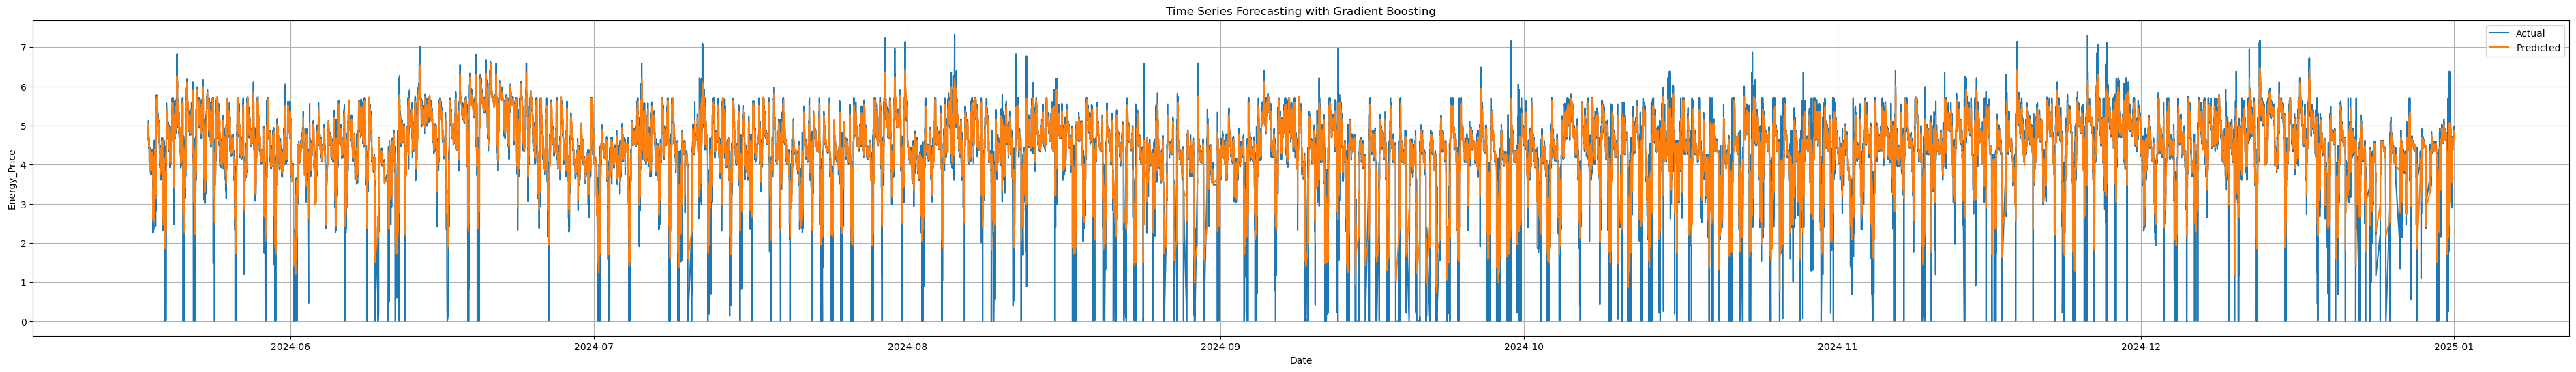

In [ ]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


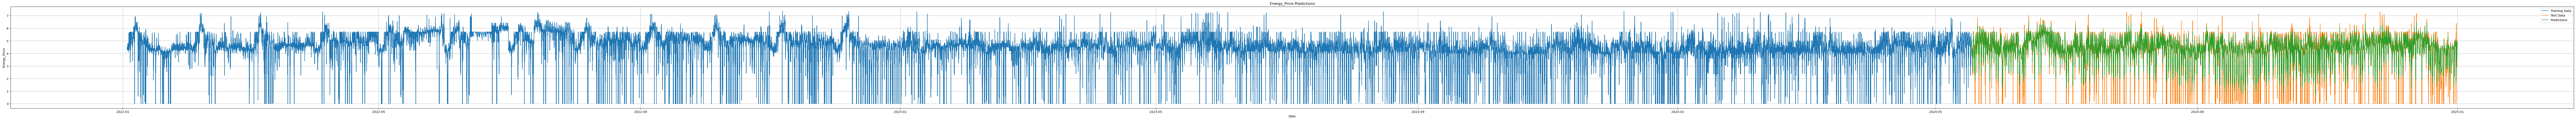

In [ ]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## TRANSPORTATION DATA

In [ ]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [ ]:
#df header
df.head()

timestamp  Energy_Demand  Energy_Price  Crude_Oil_Price  \
0  3/1/22 0:00        7294.03      4.370966            78.25   
1  3/1/22 0:05        7304.76      4.507557            78.25   
2  3/1/22 0:10        7176.53      4.476996            78.25   
3  3/1/22 0:15        7247.72      4.497028            78.25   
4  3/1/22 0:20        7169.96      4.478132            78.25   

   Natural_Gas_Price  Rainfall  Carbon_Intensity  Renewable_Energy_Percentage  \
0               3.74       0.0            313.43                        58.81   
1               3.74       0.0            313.43                        58.81   
2               3.74       0.0            313.43                        58.81   
3               3.74       0.0            313.43                        58.81   
4               3.74       0.0            313.43                        58.81   

   Temperature  Solar_Exposure  hour  dayofweek  month     lag_1  lag_12  \
0           22               0     0          0      1       NaN     NaN   
1           22               0     0          0      1  4.370966     NaN   
2           22               0     0          0      1  4.507557     NaN   
3           22               0     0          0      1  4.476996     NaN   
4           22               0     0          0      1  4.497028     NaN   

   lag_288  lag_576  rolling_mean_24  rolling_std_24  
0      NaN      NaN              NaN             NaN  
1      NaN      NaN              NaN             NaN  
2      NaN      NaN              NaN             NaN  
3      NaN      NaN              NaN             NaN  
4      NaN      NaN              NaN             NaN

In [ ]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [ ]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

In [ ]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [ ]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 0.2156
Mean Squared Error on the Test Set: 0.2025
Root Mean Squared Error on the Test Set: 0.4500
R^2 Score: 0.7138
Adjusted R^2 Score: 0.7137


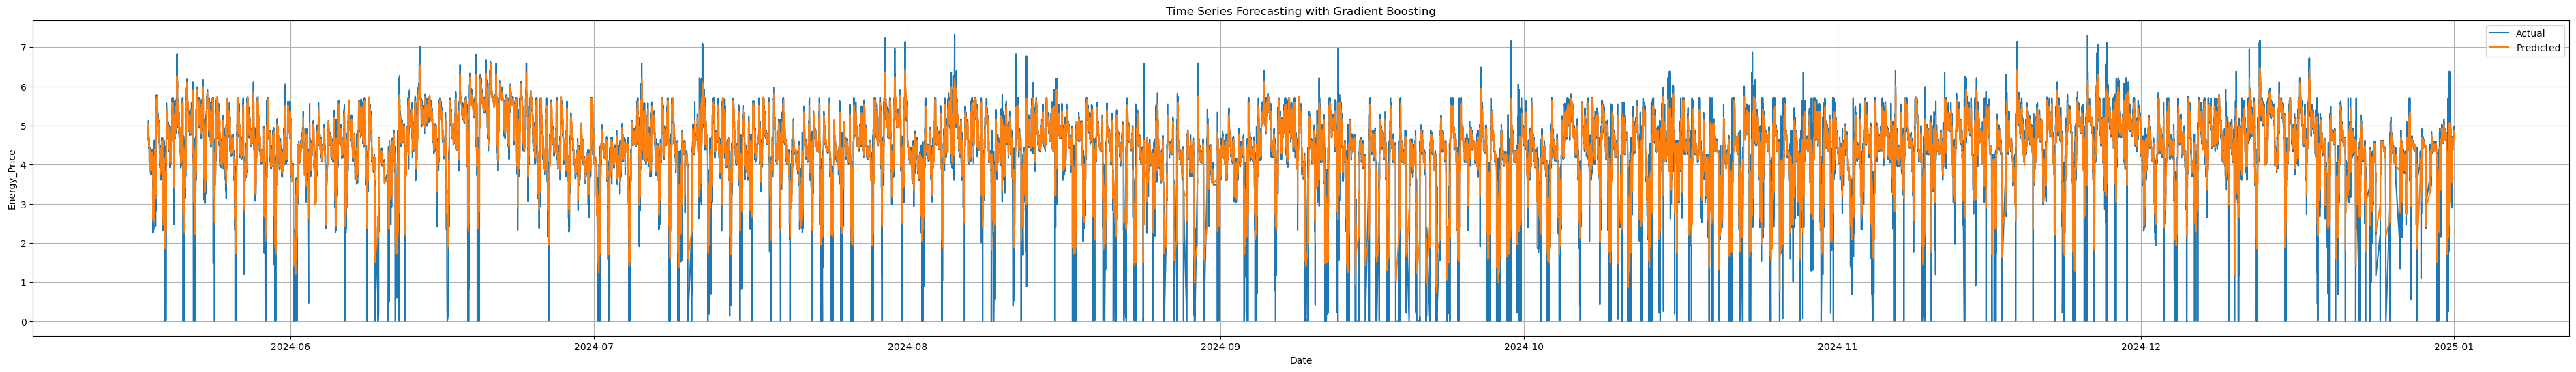

In [ ]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


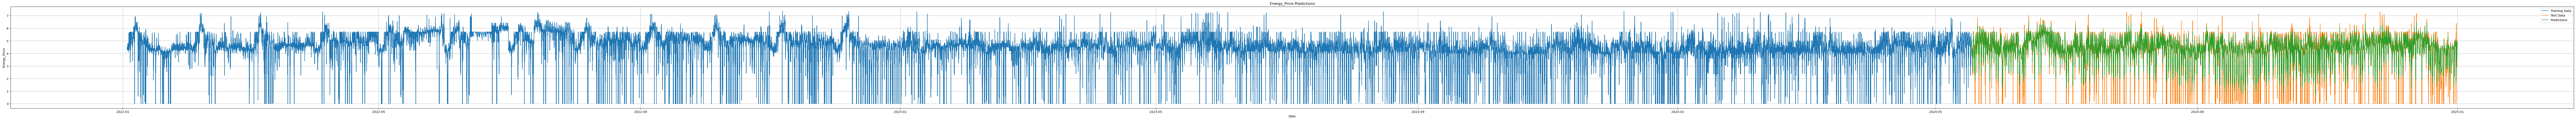

In [ ]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()